## GridWorld

In [1]:
from environment import Gridworld

game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [2]:
game.makeMove('d')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.reward()

-1

In [4]:
player, goal, pit, wall = game.board.render_np()
player, goal, pit, wall

(array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 array([[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 array([[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=uint8))

## Neural Network Q Function

In [26]:
import numpy as np
import torch
import random
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [27]:
def create_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(64, 150),
        torch.nn.ReLU(),
        torch.nn.Linear(150, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 4)
    )
    return model

In [28]:
action_set = {0:'u', 1:'d', 2: 'l', 3:'r'}

In [32]:
def get_state(game):
    state = game.board.render_np().reshape(1, 64)
    noise = np.random.rand(1, 64)/10.0
    return state + noise

def train_model(model, mode='static'):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    gamma = 0.9
    epsilon = 1.0
    epochs = 1_000
    losses = []
    for i in tqdm(range(epochs)):
        # Start a game in each epoch.
        game = Gridworld(size=4, mode=mode)
        state_ = get_state(game)
        state1 =  torch.from_numpy(state_).float()
        while True:
            qval = model(state1)
            qval_ = qval.data.numpy()
    
            # Select an action using epsilon-greedy method.
            if random.random() < epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)
    
            action = action_set[action_]
            game.makeMove(action)
            state2_ = get_state(game)
            state2 = torch.from_numpy(state2_).float()
            reward = game.reward()
    
            with torch.no_grad():
                newQ = model(state2.reshape(1, 64))
            maxQ = torch.max(newQ)
            if reward == -1:
                Y = reward + (gamma * maxQ)
            else:
                Y = reward
            Y = torch.Tensor([Y]).detach()
            X = qval.squeeze()[action_]
            loss = loss_fn(X, Y)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            state1 = state2
            # If the reward is -1, the game hasn't been won or lost 
            # and is still in progress.
            if reward != -1:
                break
        if epsilon > 0.1:
            epsilon -= 1/epochs
    return losses

model = create_model()
losses = train_model(model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.53it/s]


Text(0, 0.5, 'Loss')

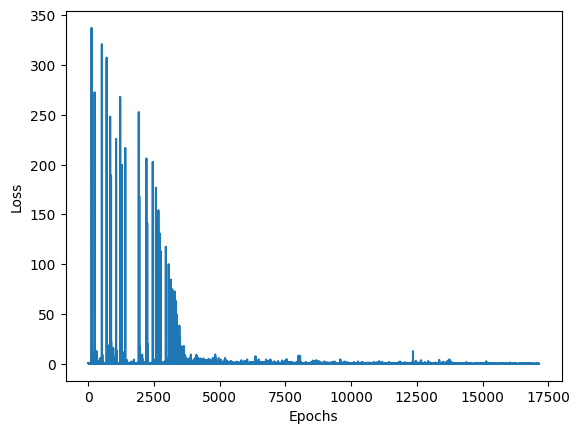

In [33]:
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [34]:
def test_model(model, mode='static', display=True):
    test_game = Gridworld(size=4, mode=mode)
    
    def loop():    
        state_ = get_state(test_game)
        state = torch.from_numpy(state_).float()
        
        i = 0
        while True:
            qval = model(state)
            qval_ = qval.data.numpy()
            action_ = np.argmax(qval_)
            action = action_set[action_]
            test_game.makeMove(action)
            if display:
                print(f'Move #: {i}; Taking action: {action} {test_game.reward()}')
                print(test_game.display())
            reward = test_game.reward()
            if reward != -1:
                if reward > 0:
                    return f'Game won! Reward: {reward}'
                else:
                    return f'Game lost. Reward: {reward}'
                    
            i += 1
            if i > 15:
                return 'Game lost; too many moves.'
            state_ = get_state(test_game)
            state = torch.from_numpy(state_).float()
            
    if display:
        print('Initial State:')
        print(test_game.display())
        print(loop())
    else:
        loop()

In [37]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l -1
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u -1
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u 10
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


In [41]:
test_model(model, 'random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 0; Taking action: u -1
[[' ' ' ' ' ' ' ']
 [' ' 'P' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 1; Taking action: u -1
[[' ' 'P' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 2; Taking action: u -1
[[' ' 'P' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 3; Taking action: u -1
[[' ' 'P' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 4; Taking action: u -1
[[' ' 'P' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 5; Taking action: u -1
[[' ' 'P' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 6; Taking action: u -1
[[' ' 'P' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 7; Taking action: u -1
[[' ' 'P' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 8; Taking action: u -1
[[' ' 'P' ' '

In [39]:
model = create_model()
losses = train_model(model, 'random')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.77it/s]


Text(0, 0.5, 'Loss')

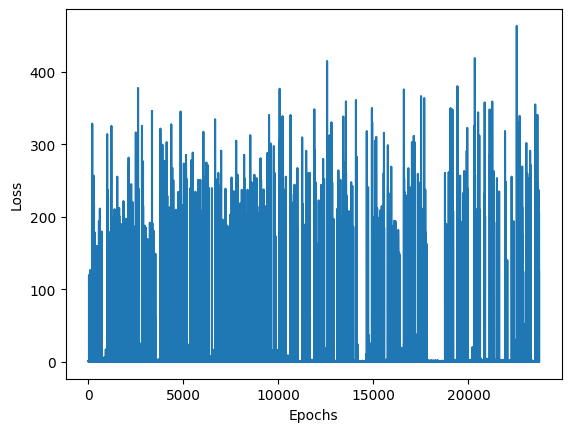

In [42]:
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

The loss plot for Q-learning in random model, which doesn't show any sign of convergence.